In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
import muon as mu
from muon import atac as ac
import random
import os
import openpyxl
import scipy
from scipy.stats import median_abs_deviation

In [38]:
adata = sc.read_10x_mtx('/Users/alexandra/Desktop/Data/Single-Cell/hg19_10xCloud_aligned_data/filtered_feature_bc_matrix', gex_only = False)

gex_rows = list(map(lambda x: x == 'Gene Expression', adata.var['feature_types']))
atac_rows = list(map(lambda x: x == 'Peaks', adata.var['feature_types']))

adata_gem = adata[:, gex_rows].copy()
adata_atac = adata[:, atac_rows].copy()

adata_gem.var_names_make_unique()
adata_atac.var_names_make_unique()

In [39]:
# mitochondrial genes
adata_gem.var["mt"] = adata_gem.var_names.str.startswith("MT-")
# ribosomal genes
adata_gem.var["ribo"] = adata_gem.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata_gem.var["hb"] = adata_gem.var_names.str.contains("^HB[^(P)]")

In [40]:
# calculate qc metrics
sc.pp.calculate_qc_metrics(
    adata_gem, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata_gem

AnnData object with n_obs × n_vars = 11112 × 20346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

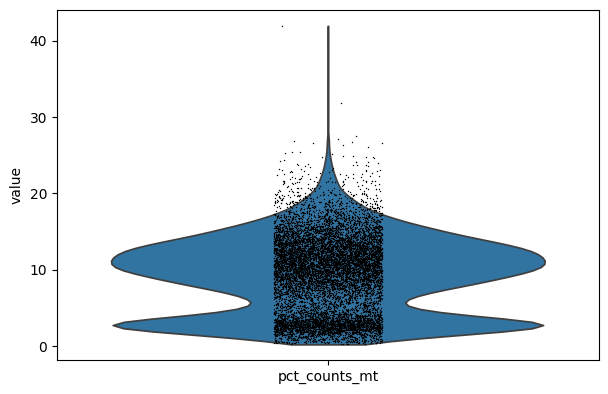

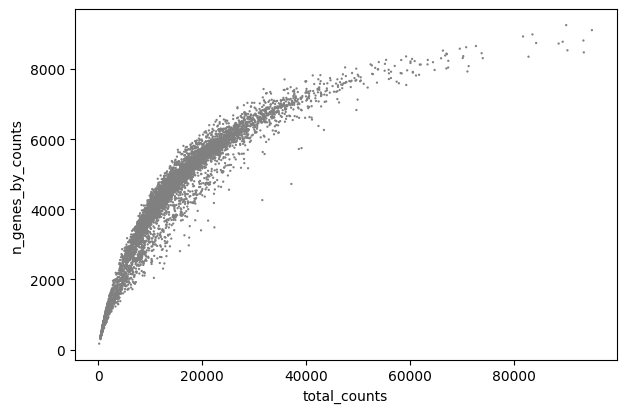

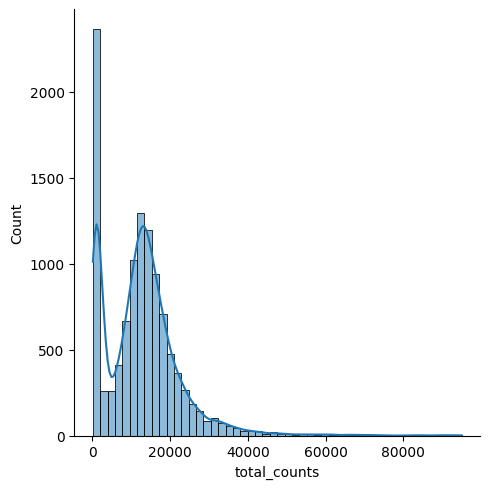

In [41]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [42]:
# filter cells by MADs
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M )
    return outlier 

In [43]:
# filter cells by MADs
adata_gem.obs["outlier"] = (
    is_outlier(adata_gem, "total_counts", 5)
  | is_outlier(adata_gem, "n_genes_by_counts", 5)
)

adata_gem.obs.outlier.value_counts()

outlier
False    10937
True       175
Name: count, dtype: int64

In [44]:
adata_gem.obs["mt_outlier"] = adata_gem.obs["pct_counts_mt"] > 20
adata_gem.obs.mt_outlier.value_counts()

mt_outlier
False    10957
True       155
Name: count, dtype: int64

In [45]:
adata_gem = adata_gem[~adata_gem.obs["outlier"] & ~adata_gem.obs.mt_outlier].copy()
adata_gem

AnnData object with n_obs × n_vars = 10791 × 20346
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

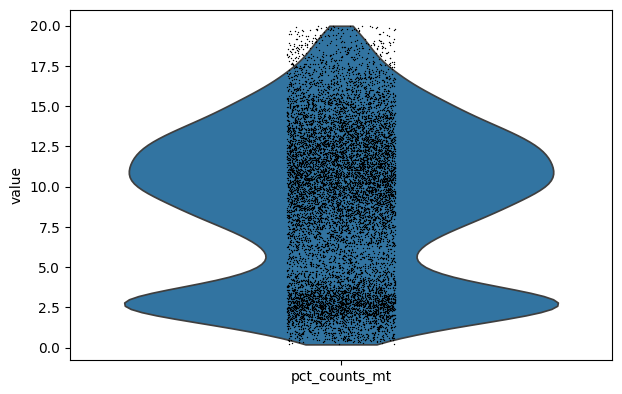

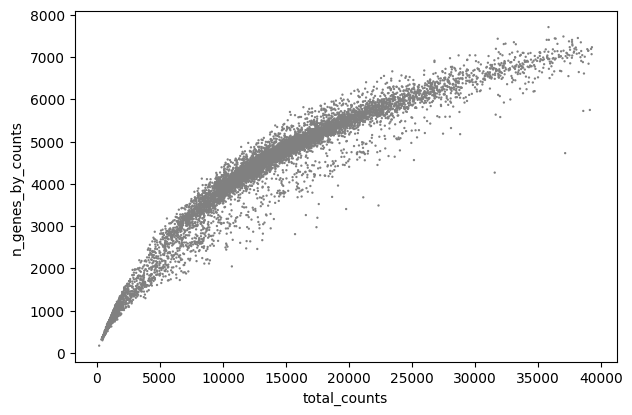

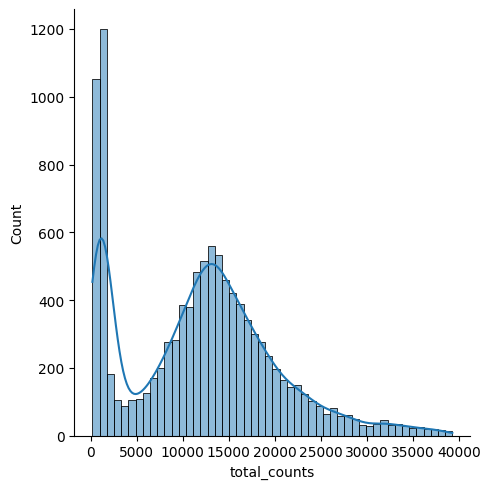

In [46]:
p1 = sc.pl.violin(adata_gem, ["pct_counts_mt"])
p2 = sc.pl.scatter(adata_gem, x="total_counts", y="n_genes_by_counts")
p3 = sns.displot(adata_gem.obs["total_counts"], bins=50, kde=True)

In [47]:
# Optional: keep total validation gene
#valid_csv = pd.read_excel("/Users/alexandra/Desktop/Data/CRISPRiFlowFISH/41588_2019_538_MOESM3_ESM.xlsx",  sheet_name="Supplementary Table 6a", skiprows=1)
#valid_gene_list = set(valid_csv["Gene"])
#len(valid_gene_list)

In [48]:
# fitler genes
sc.pp.filter_genes(adata_gem, min_cells=20)
adata_gem = adata_gem[:,~adata_gem.var["mt"]& ~adata_gem.var["ribo"] & ~adata_gem.var["hb"]].copy()
adata_gem

AnnData object with n_obs × n_vars = 10791 × 13703
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'

In [49]:
# Normalization
sc.pp.normalize_total(adata_gem, target_sum=1e6)
sc.pp.log1p(adata_gem)

In [50]:
# Select highly variable genes
adata_gem_hvg = adata_gem.copy()
sc.pp.highly_variable_genes(adata_gem_hvg, n_top_genes=3000, inplace=True)

adata_gem_hvg = adata_gem_hvg[:, adata_gem_hvg.var.highly_variable].copy()

In [51]:
# UMAP
sc.pp.neighbors(adata_gem_hvg, n_neighbors=15, n_pcs=50)
sc.tl.umap(adata_gem_hvg, alpha = 1, gamma = 0.1)

/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/scanpy/tools/_utils.py:40: UserWarning: You’re trying to run this on 3000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


In [52]:
# clustering
sc.tl.leiden(adata_gem_hvg)

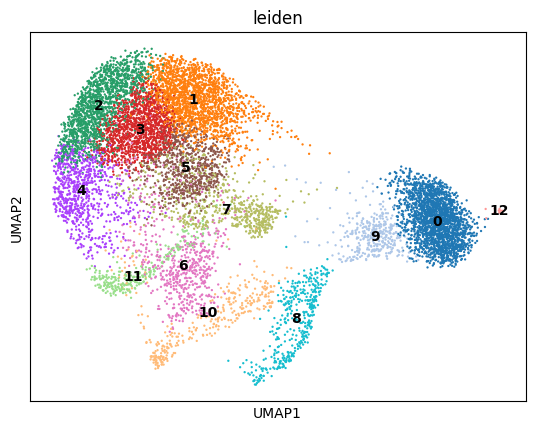

In [53]:
sc.pl.umap(adata_gem_hvg, color=["leiden"], legend_loc="on data", ncols=3)

In [54]:
# cell cycle scoring
# Load cell cycle genes defined in Tirosh et al, 2015. It is a list of 97 genes, represented by their gene symbol. 
cell_cycle_genes = [x.strip() for x in open("/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/Reference/regev_lab_cell_cycle_genes.txt")]

# Here we define two lists, genes associated to the S phase and genes associated to the G2M phase
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

sc.tl.score_genes_cell_cycle(adata_gem, s_genes=s_genes, g2m_genes=g2m_genes)

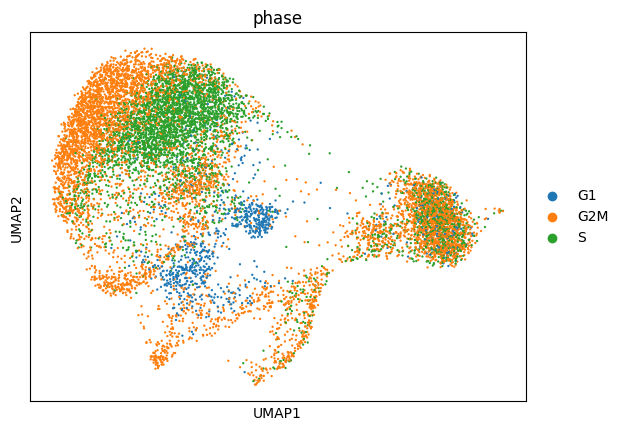

In [55]:
adata_gem_hvg.obs["phase"] = adata_gem.obs["phase"]
sc.pl.umap(adata_gem_hvg, color=["phase"], ncols=3)

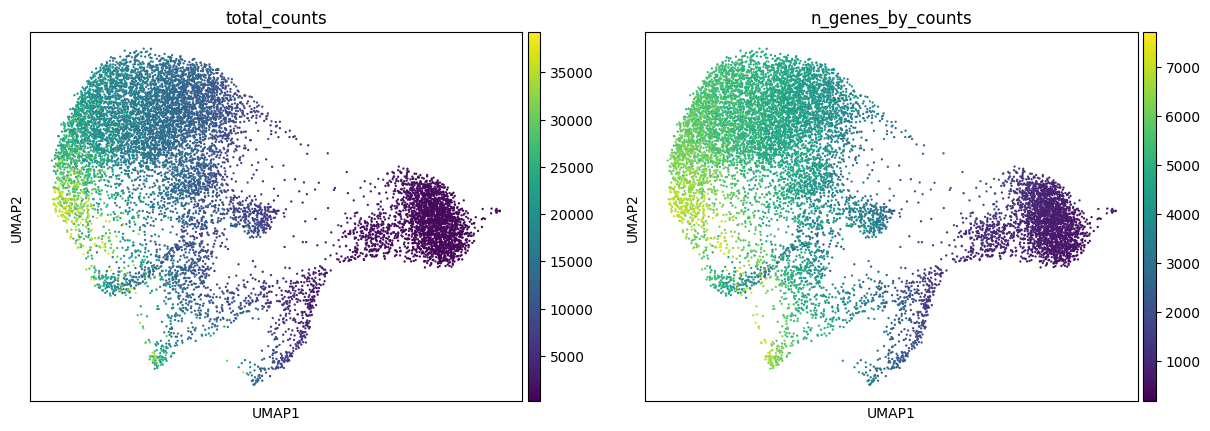

In [56]:
sc.pl.umap(adata_gem_hvg, color=['total_counts', 'n_genes_by_counts'], color_map='viridis')

In [57]:
import sys
import os

# Add the Functions folder to your path
sys.path.append(os.path.abspath("/Users/alexandra/Desktop/EG-CLR/Functions"))

# Now import your functions
from QC_functions import *

In [58]:
adata_gem, adata_atac = find_common_cell(adata_gem, adata_atac)
adata_atac = limit_to_Chr(adata_atac, key = 'gene_ids')

adata_RNA: 10791 , adata_ATAC: 10791


In [59]:
# ATAC-seq peak length
peak_list = list(adata_atac.var_names)

length = []
for peak in peak_list:
    _,coordnats = peak.split(":")
    start,end = map(int,coordnats.split("-"))
    length.append(end-start)
    
average_length = np.mean(length)
print("Average length for ATAC-seq is:", average_length)

Average length for ATAC-seq is: 847.644787143379


In [60]:
# calcaulte genereal qc metrics for ATAC-seq
sc.pp.calculate_qc_metrics(adata_atac,percent_top = None, log1p = False, inplace = True)

adata_atac.obs.rename(columns = {"n_genes_by_counts":"n_fragment_by_counts","total_counts":"total_fragment_counts"}, 
                      inplace = True)
adata_atac.obs["log_total_fragment_counts"] = np.log1p(adata_atac.obs["total_fragment_counts"])

In [61]:
# calculate nucleosome signal
mu.atac.tl.locate_file(adata_atac, file = "/Volumes/G-DRIVE mobile USB-C/Single-cell_data/K562/10x/ISSAACC-seq_generated/hg19_10xCloud_aligned_data/atac_fragments.tsv.gz", key = "fragments")
ac.tl.nucleosome_signal(adata_atac, n=10e3 * adata_atac.n_obs)

Reading Fragments: 100%|██████████| 107910000/107910000 [04:31<00:00, 397434.31it/s]


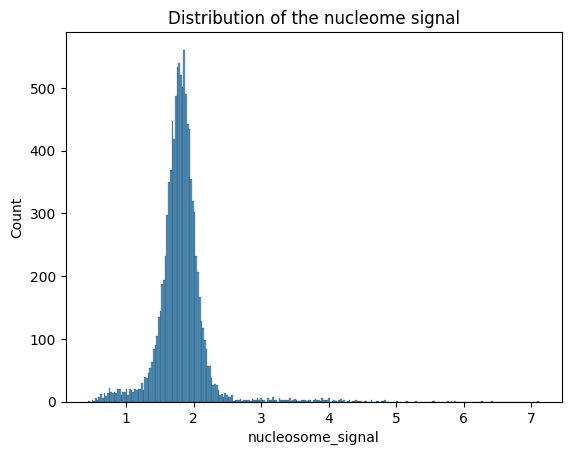

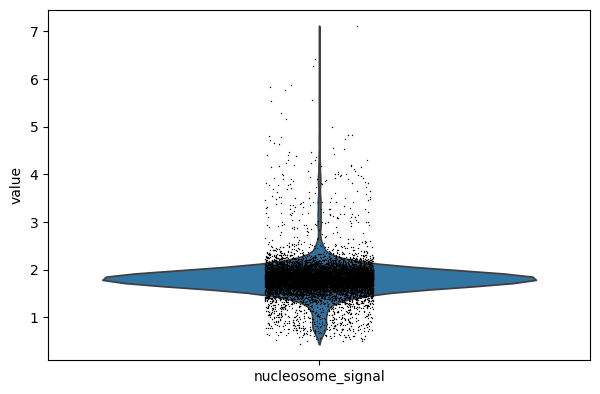

In [62]:
sns.histplot(adata_atac.obs, x="nucleosome_signal")
plt.title("Distribution of the nucleome signal")
sc.pl.violin(adata_atac, "nucleosome_signal")

In [63]:
# filter nucleosome signal
mu.pp.filter_obs(adata_atac, "nucleosome_signal", lambda x: x <= 3)
adata_atac

AnnData object with n_obs × n_vars = 10637 × 123205
    obs: 'n_fragment_by_counts', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

In [64]:
# calculate tss enrichment
df_annotation = pd.read_csv("/Volumes/G-DRIVE mobile USB-C/Single-cell_data/K562/10x/ISSAACC-seq_generated/hg19_10xCloud_aligned_data/atac_peak_annotation.tsv", sep='\t')
df_annotation = df_annotation[['chrom', 'start', 'end']]
df_annotation.columns = ['Chromosome', 'Start', 'End']

tss = ac.tl.tss_enrichment(adata_atac,  n_tss=5000, random_state=42, features = df_annotation)
adata_atac

Fetching Regions...: 100%|██████████| 5000/5000 [01:19<00:00, 62.80it/s]
/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/anndata/_core/anndata.py:401: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 10637 × 123205
    obs: 'n_fragment_by_counts', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

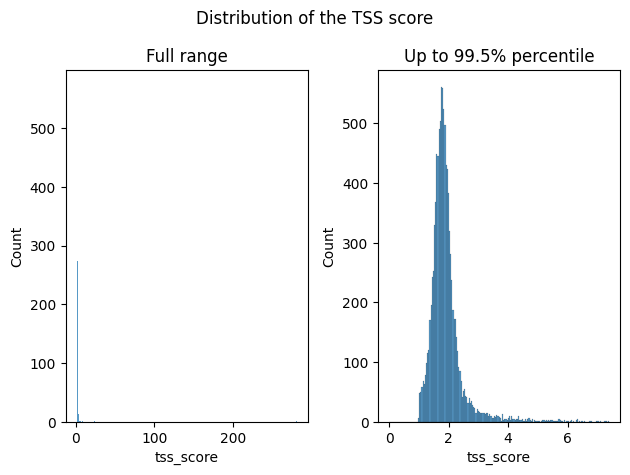

In [72]:
fig, axs = plt.subplots(1, 2)

p1 = sns.histplot(adata_atac.obs, x="tss_score", ax=axs[0])
p1.set_title("Full range")

p2 = sns.histplot(adata_atac.obs,  x="tss_score",binrange=(0, adata_atac.obs["tss_score"].quantile(0.995)),ax=axs[1])
p2.set_title("Up to 99.5% percentile")

plt.suptitle("Distribution of the TSS score")
plt.tight_layout()

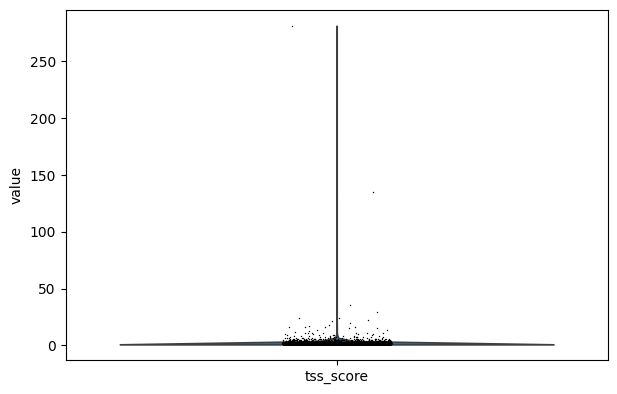

In [73]:
sc.pl.violin(adata_atac, ["tss_score"], show=False)
p2.set_title("TSS score distribution")
p2.set_ylim(0, 200)
plt.show()

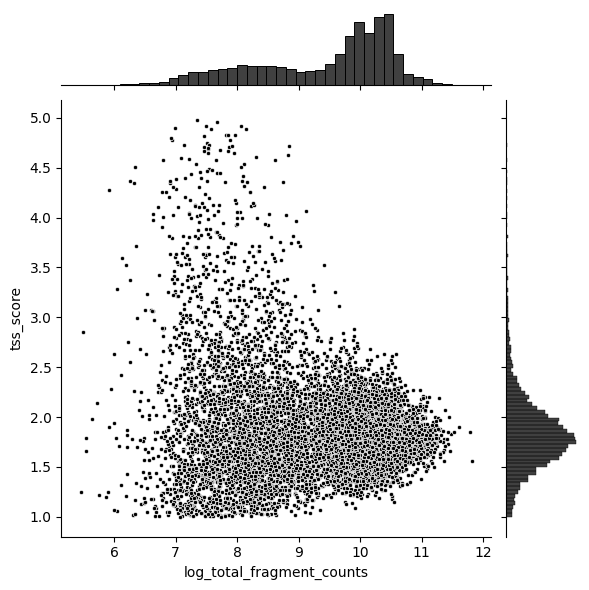

In [74]:
g = sns.jointplot(
    data=adata_atac[(adata_atac.obs["tss_score"] < 5)].obs,
    x="log_total_fragment_counts",
    y="tss_score",
    color="black",
    marker=".",
)

plt.show()

In [68]:
mu.pp.filter_obs(adata_atac, "tss_score", lambda x: x >=1)
adata_atac

AnnData object with n_obs × n_vars = 10384 × 123205
    obs: 'n_fragment_by_counts', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

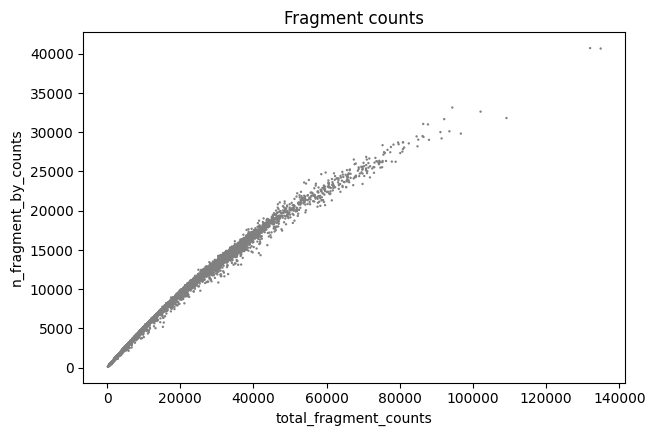

In [69]:
p1 = sc.pl.scatter(adata_atac, x = "total_fragment_counts", y = "n_fragment_by_counts", show = False)
p1.set_title("Fragment counts")
plt.show()

In [76]:
mu.pp.filter_obs(adata_atac, "total_fragment_counts", lambda x: x <= 80000)
adata_atac

AnnData object with n_obs × n_vars = 10359 × 123205
    obs: 'n_fragment_by_counts', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

In [85]:
# Removel peaks overlap with blackslisted regions
from pybedtools import BedTool
blacklist = BedTool("/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/Reference/hg19-blacklist.bed")

In [220]:
peak_df = adata_atac.var.index.to_frame().astype(str)
peak_df.index = peak_df.index.astype(str)  # make sure it's string type
peak_df = peak_df.index.str.extract(r'^(chr\w+):(\d+)-(\d+)$')


peak_df.rename(columns = {0:"chrom", 1:"start", 2:"end"}, inplace = True)
peak_df['start'] = peak_df['start'].astype(int)
peak_df['end'] = peak_df['end'].astype(int)

peak_df[['chrom', 'start','end']].to_csv("/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/Reference/10x_k562_atac_peaks.bed", sep = '\t', index = False, header = False)

In [222]:
peaks = BedTool("/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/Reference/10x_k562_atac_peaks.bed")
blacklist = BedTool("/Users/alexandra/Desktop/EG-CLR/SingleCellDataAnalysis/Reference/hg19-blacklist.bed")

# Subtract blacklist regions
clean_peaks = peaks.intersect(blacklist, v=True)

In [ ]:
# Extract the clean peak coordinates into the same format as in adata_atac.var_names
remaining_peaks = [f"{x.chrom}:{x.start}-{x.end}" for x in clean_peaks]

# Subset your AnnData object
adata_atac_clean = adata_atac[:, adata_atac.var_names.isin(remaining_peaks)].copy()
adata_atac_clean

AnnData object with n_obs × n_vars = 10359 × 122646
    obs: 'n_fragment_by_counts', 'total_fragment_counts', 'log_total_fragment_counts', 'nucleosome_signal', 'tss_score'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'files'

In [228]:
adata_gem, adata_atac = find_common_cell(adata_gem, adata_atac_clean)

adata_RNA: 10359 , adata_ATAC: 10359


In [229]:

# Create a multimodal object
mdata_final = mu.MuData({'rna': adata_gem, 'atac': adata_atac})

# Save to .h5mu
mdata_final.write("/Volumes/G-DRIVE mobile USB-C/Single-cell_data/K562/10x/ISSAACC-seq_generated/hg19_10xCloud_aligned_data/processed_data/multiome_data.h5mu")

/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)
/opt/anaconda3/envs/CLR/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull 